In [35]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.neighbors import LocalOutlierFactor
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV

from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import sklearn.metrics as metrics
#from sklearn import metrics

In [2]:
def plot_conf_mtx(model, X, y):
    y_pred = model.predict(X)
    cm = confusion_matrix(y, y_pred)
    labels = ['No churn', 'Churn']
    fig = plt.figure(figsize=(12,12))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

def plot_roc_curve(model, X_test, y_test):
    y_pred = model.predict(X_test)
    print("Accuracy", metrics.accuracy_score(y_test, y_pred))

    y_pred_proba = model.predict_proba(X_test)[::,1]
    fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
    auc = metrics.roc_auc_score(y_test, y_pred_proba)
    fig, ax = plt.subplots(figsize=(10,10))
    plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
    plt.legend(loc=4)
    plt.show()
    
    return y_pred

## Data exploration and baseline model

First, let's read our data into a dataframe and check the percenteage of missing values!

In [3]:
df = pd.read_csv('./telco.csv') 

In [4]:
df

,region,tenure,age,marital,address,income,ed,employ,retire,gender,...,voice,pager,internet,callid,callwait,forward,confer,ebill,custcat,churn
0,2,13,44,1,9,64.0,4,5,0.0,0,...,0,0,0,0,0,1,0,0,1,1
1,3,11,33,1,7,136.0,5,5,0.0,0,...,1,1,0,1,1,1,1,0,4,1
2,3,68,52,1,24,116.0,1,29,0.0,1,...,0,0,0,1,1,0,1,0,3,0
3,2,33,33,0,12,33.0,2,0,0.0,1,...,0,0,0,0,0,0,0,0,1,1
4,2,23,30,1,9,30.0,1,2,0.0,0,...,0,0,0,1,0,1,1,0,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3,10,39,0,0,27.0,3,0,0.0,1,...,0,0,0,0,0,0,0,1,1,0
996,1,7,34,0,2,22.0,5,5,0.0,1,...,0,0,0,0,0,0,0,0,1,0
997,3,67,59,0,40,944.0,5,33,0.0,1,...,1,1,1,1,1,1,1,1,4,0
998,3,70,49,0,18,87.0,2,22,0.0,1,...,1,0,0,1,1,1,1,0,3,0


In [5]:
df.columns

Index(['region', 'tenure', 'age', 'marital', 'address', 'income', 'ed',
       'employ', 'retire', 'gender', 'reside', 'tollfree', 'equip', 'callcard',
       'wireless', 'longmon', 'tollmon', 'equipmon', 'cardmon', 'wiremon',
       'longten', 'tollten', 'equipten', 'cardten', 'wireten', 'multline',
       'voice', 'pager', 'internet', 'callid', 'callwait', 'forward', 'confer',
       'ebill', 'custcat', 'churn'],
      dtype='object')

In [6]:
percent_missing = df.isna().sum() * 100 / len(df)
missing_value_df = pd.DataFrame({'column_name': df.columns,
                                 'percent_missing': percent_missing})
missing_value_df

,column_name,percent_missing
region,region,0.0
tenure,tenure,0.0
age,age,0.0
marital,marital,0.0
address,address,0.0
income,income,0.0
ed,ed,0.0
employ,employ,0.0
retire,retire,0.0
gender,gender,0.0


Thankfully there's no missing data, so there's no need to delete or replace missing values.

In [7]:
df['churn'].value_counts()

0    726
1    274
Name: churn, dtype: int64

We can see that we're dealing with imbalances classes, which we need to be careful about. Because of this, I'll try oversampling the dataset later to see if it improves performance. Also, let's quickly check a model before we even touch the data to get a baseline performance. Usually logistic regression is a good method for churn prediction/classification, and since the dataset is quite small, I don't think we need to overthink model selection. Let's split the data into train and test sets (I'm going to be using the CrossValidated version of logistic regression, so there's no need for a separate dev set to be defined explicitly).

Since we're dealing with a classification problem (and an imbalanced one at that), a regular accuracy score might result in overly optimistic results, so instead I'll be using the ROC AUC scorer and also take a look at the classification report and f1 scores to see how well the model is dealing with the classes separately.

In [8]:
X = df.loc[:, df.columns != 'churn']
y = df['churn']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42)

In [9]:
clf = LogisticRegressionCV(cv=5, solver='liblinear', max_iter=10000, scoring="roc_auc").fit(X_train, y_train)
print(clf.score(X_train, y_train))
print(clf.score(X_test, y_test))

0.8227184058567975
0.8165548098434005


We're using a 5-fold cross-validation, and getting a result of 0.82 ROC AUC score on the test set, which is not bad for starters. I also took a look at the train set score, just to check the model is not overfitting (the value of 0.82 suggests it's not). Let's plot the ROC AUC curve and take a look at the classification report!

Accuracy 0.78


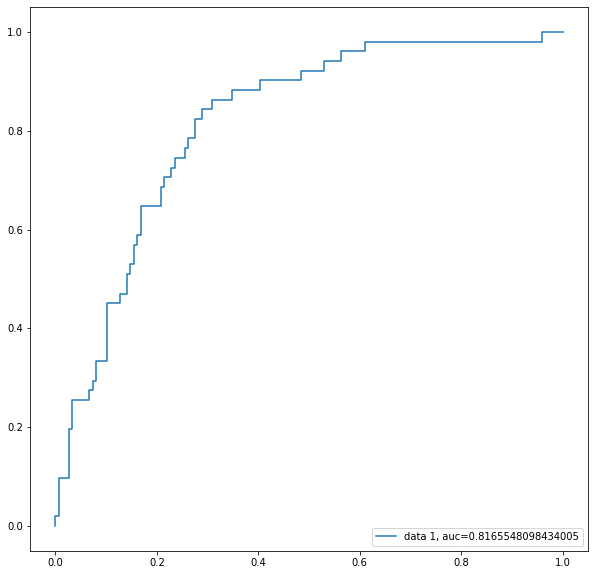

              precision    recall  f1-score   support

           0       0.83      0.89      0.86       149
           1       0.59      0.45      0.51        51

    accuracy                           0.78       200
   macro avg       0.71      0.67      0.68       200
weighted avg       0.77      0.78      0.77       200



In [10]:
y_pred = plot_roc_curve(clf, X_test, y_test)
print(classification_report(y_test, y_pred))

## Data preprocessing

The recall for the churn class seems low, and generally, the model seems to have an issue in predicting the churn class (out of a 100 churn predictions, only 59 will actually churn). Let's see if we can improve upon this by preprocessing the data!

In [13]:
categorical_cols = ['region', 'custcat']

binary_cols = []
for col in df.columns:
    if df[col].value_counts().shape[0] == 2:
        binary_cols.append(col)
binary_cols.remove('churn')

continuous_cols = list(np.setdiff1d(df.columns, binary_cols))
continuous_cols.remove('churn')
continuous_cols = [ e for e in continuous_cols if  e not in categorical_cols]
len(df.columns) == len(categorical_cols) + len(binary_cols) + len(continuous_cols) + 1

True

Let's take a look at each column, to see if there's a difference between the categories in regards to churn!

In [12]:
for col in binary_cols:
    print(df[[col,'churn']].groupby(['churn']).mean())

        marital
churn          
0      0.506887
1      0.463504
         retire
churn          
0      0.060606
1      0.010949
         gender
churn          
0      0.515152
1      0.521898
       tollfree
churn          
0      0.480716
1      0.456204
          equip
churn          
0      0.294766
1      0.627737
       callcard
churn          
0      0.747934
1      0.492701
       wireless
churn          
0      0.258953
1      0.394161
       multline
churn          
0      0.479339
1      0.463504
          voice
churn          
0      0.258953
1      0.423358
          pager
churn          
0      0.225895
1      0.354015
       internet
churn          
0      0.287879
1      0.580292
         callid
churn          
0      0.487603
1      0.463504
       callwait
churn          
0      0.504132
1      0.434307
        forward
churn          
0      0.498623
1      0.478102
         confer
churn          
0      0.522039
1      0.448905
          ebill
churn          
0      0

It seems like gender doesn't really make a difference, we could remove it from the dataset. However, since we only have a tiny set, computing time is not an issue, so I'll keep it in, won't do any harm.

In [13]:
for col in continuous_cols:
    print(df[[col,'churn']].groupby(['churn']).mean())

         address
churn           
0      13.056474
1       7.562044
             age
churn           
0      43.633609
1      36.518248
         cardmon
churn           
0      15.138085
1      10.185219
          cardten
churn            
0      724.202479
1      291.980839
             ed
churn          
0      2.517906
1      3.076642
          employ
churn           
0      12.684573
1       6.489051
        equipmon
churn           
0      11.249793
1      22.089234
         equipten
churn            
0      454.225895
1      495.857117
          income
churn           
0      83.538567
1      61.627737
         longmon
churn           
0      13.456336
1       7.130657
          longten
churn            
0      707.667011
1      220.013869
         reside
churn          
0      2.322314
1      2.354015
          tenure
churn           
0      40.468320
1      22.430657
         tollmon
churn           
0      14.209366
1      10.795620
         tollten
churn           
0      642

For similar reasons we would want to remove the Education and Reside columns since those also do not differ much between the churning and non-churning groups. But since we're not pressed for computing power, I'll leave them in.

In [14]:
for col in categorical_cols:
    print(df[[col,'churn']].groupby([col]).mean())

           churn
region          
1       0.279503
2       0.281437
3       0.261628
            churn
custcat          
1        0.312030
2        0.271889
3        0.156584
4        0.372881


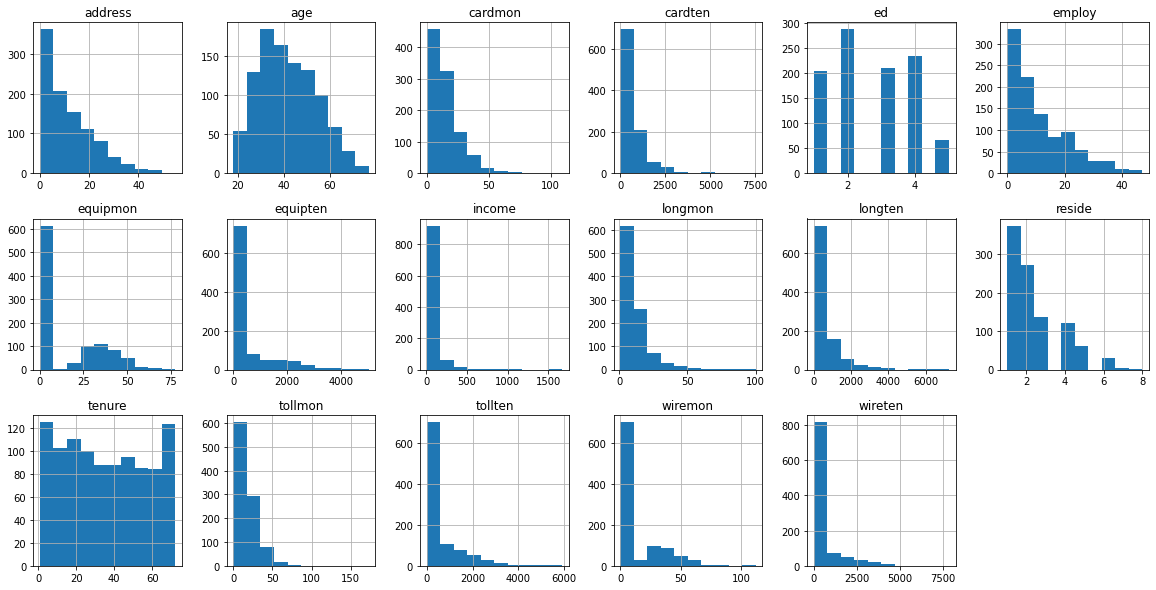

In [15]:
df[continuous_cols].hist(layout=(3, 6), figsize=(20, 10))
plt.show()

We can see there are outliers in the dataset, more on this later.

Let's one-hot-encode our categorical columns, since they don't contain ordinal data!

In [16]:
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)
df

,tenure,age,marital,address,income,ed,employ,retire,gender,reside,...,callwait,forward,confer,ebill,churn,region_2,region_3,custcat_2,custcat_3,custcat_4
0,13,44,1,9,64.0,4,5,0.0,0,2,...,0,1,0,0,1,1,0,0,0,0
1,11,33,1,7,136.0,5,5,0.0,0,6,...,1,1,1,0,1,0,1,0,0,1
2,68,52,1,24,116.0,1,29,0.0,1,2,...,1,0,1,0,0,0,1,0,1,0
3,33,33,0,12,33.0,2,0,0.0,1,1,...,0,0,0,0,1,1,0,0,0,0
4,23,30,1,9,30.0,1,2,0.0,0,4,...,0,1,1,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,10,39,0,0,27.0,3,0,0.0,1,3,...,0,0,0,1,0,0,1,0,0,0
996,7,34,0,2,22.0,5,5,0.0,1,1,...,0,0,0,0,0,0,0,0,0,0
997,67,59,0,40,944.0,5,33,0.0,1,1,...,1,1,1,1,0,0,1,0,0,1
998,70,49,0,18,87.0,2,22,0.0,1,1,...,1,1,1,0,0,0,1,0,1,0


## Modeling

I'll now plot the correlation matrix (but will only highlight correlations stronger than ±.05)!

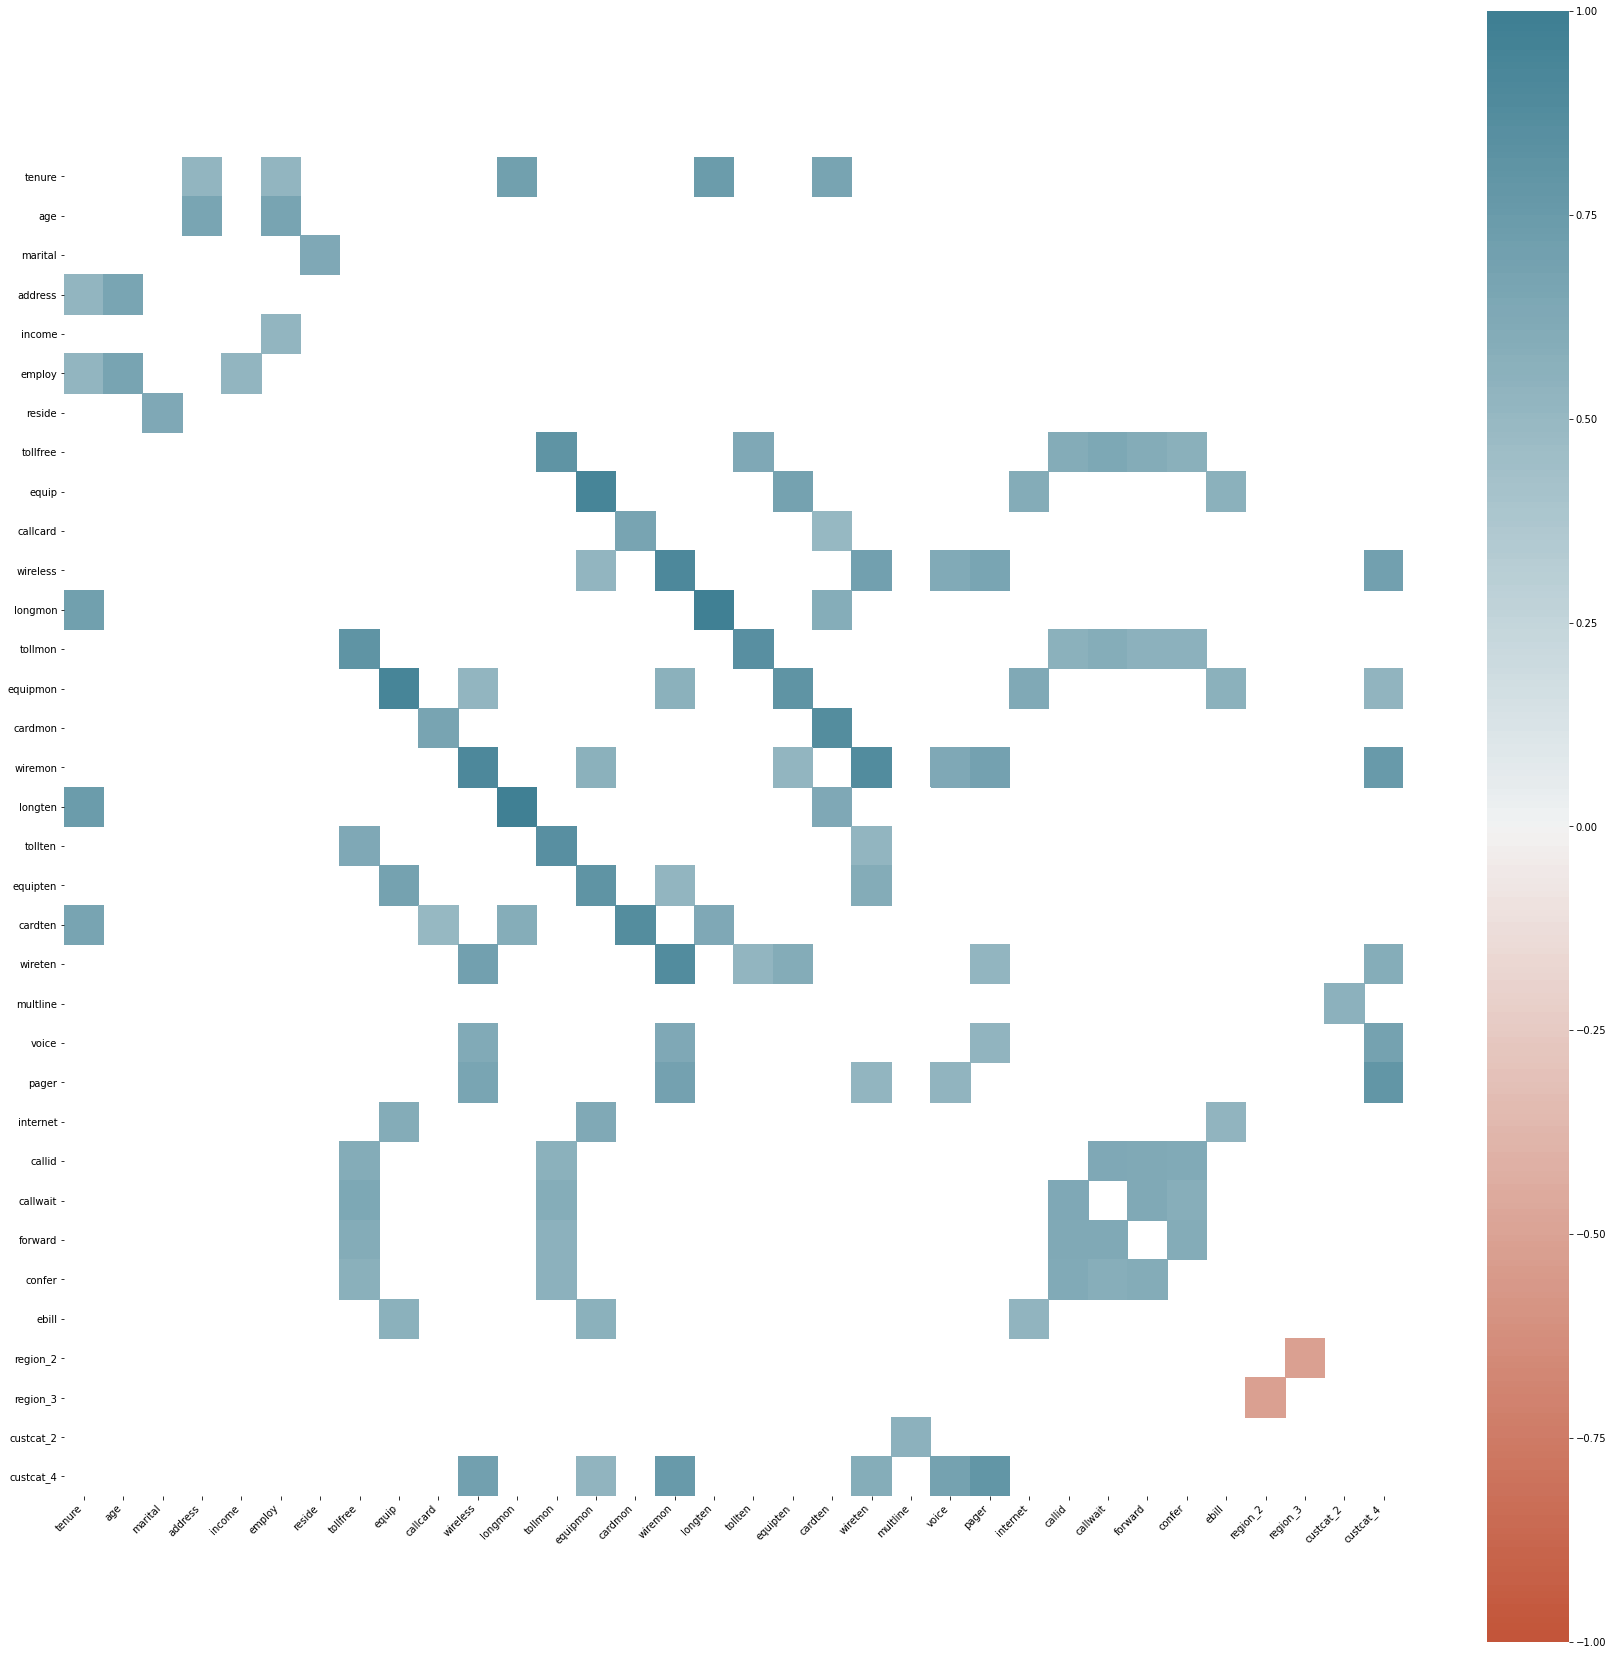

In [17]:
corr = df.corr()
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_keep = [column for column in upper.columns if (any(upper[column] > 0.5) and any(upper[column] < -0.5))]
corr = corr[((corr >= .5) | (corr <= -.5)) & (corr !=1.000)]

corr.dropna(how='all', inplace=True)
corr.dropna(how='all', axis=1, inplace=True)

fig, ax = plt.subplots(figsize=(30,30))
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

We can notice some interesting and some self-explanatory correlations, however, churn does not seem to correlate with anything highly.

Let's create a new split from the now transformed data and see if the transformations improved the performance!

In [23]:
X = df.loc[:, df.columns != 'churn']
y = df['churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [24]:
clf = LogisticRegressionCV(cv=5, solver='liblinear', max_iter=10000, scoring="roc_auc").fit(X_train, y_train)
print(clf.score(X_train, y_train))
print(clf.score(X_test, y_test))

0.819450011395877
0.8387460815047022


Accuracy 0.79


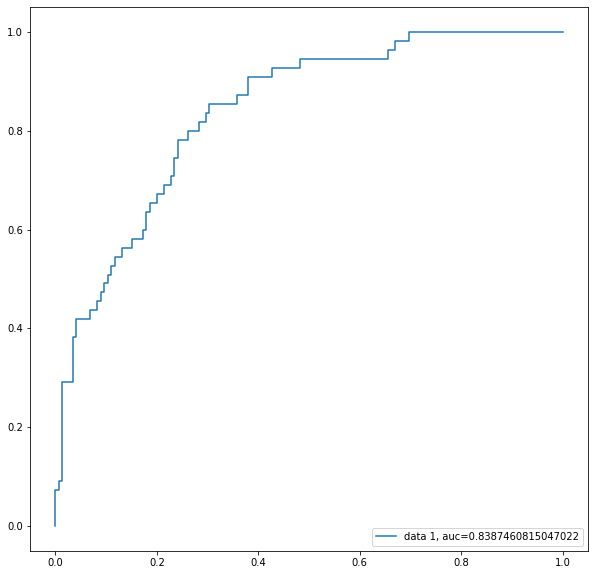

              precision    recall  f1-score   support

           0       0.83      0.89      0.86       145
           1       0.64      0.53      0.58        55

    accuracy                           0.79       200
   macro avg       0.74      0.71      0.72       200
weighted avg       0.78      0.79      0.78       200



In [25]:
y_pred = plot_roc_curve(clf, X_test, y_test)
print(classification_report(y_test, y_pred))

C:\Users\csana\.conda\envs\gensim pls\lib\site-packages\ipykernel_launcher.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  # Remove the CWD from sys.path while we load stuff.
C:\Users\csana\.conda\envs\gensim pls\lib\site-packages\ipykernel_launcher.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  # This is added back by InteractiveShellApp.init_path()


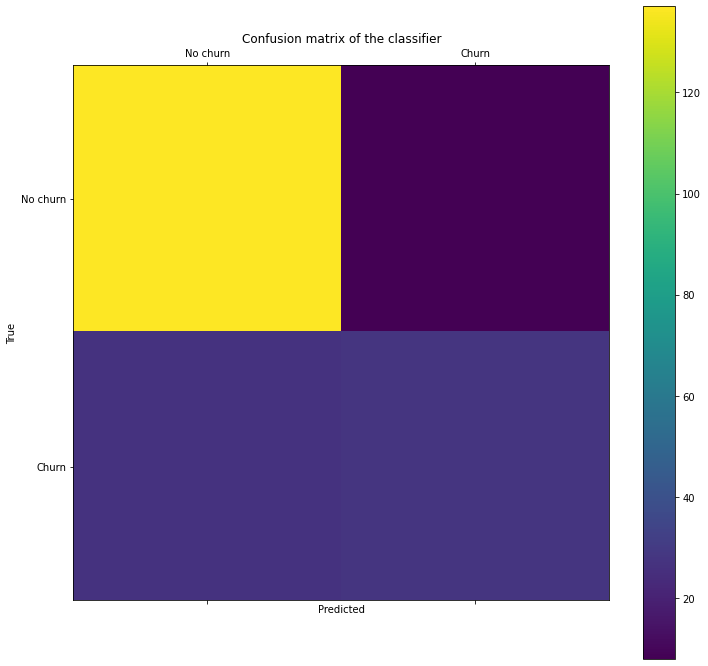

In [37]:
plot_conf_mtx(clf, X_test, y_test)

Since some methods are sensitive to non-standardized and big-valued data, let's standardize our dataset! Logistic regression is actually not one of these methods, but neural networks are, and I want to try an MLP Classifier on the data (in which case we might easily run into exploding gradients if we don't scale the dataset).

In [26]:
scaler = MinMaxScaler()

X_train[continuous_cols] = pd.DataFrame(scaler.fit_transform(X_train[continuous_cols].values), columns=continuous_cols, index=X_train.index)
X_test[continuous_cols] = pd.DataFrame(scaler.transform(X_test[continuous_cols].values), columns=continuous_cols, index=X_test.index)

C:\Users\csana\.conda\envs\gensim pls\lib\site-packages\pandas\core\frame.py:3188: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
C:\Users\csana\.conda\envs\gensim pls\lib\site-packages\pandas\core\frame.py:3188: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [27]:
clf = LogisticRegressionCV(cv=5, solver='liblinear', max_iter=10000, scoring="roc_auc").fit(X_train, y_train)
print(clf.score(X_train, y_train))
print(clf.score(X_test, y_test))

0.8120466209259739
0.838871473354232


Accuracy 0.825


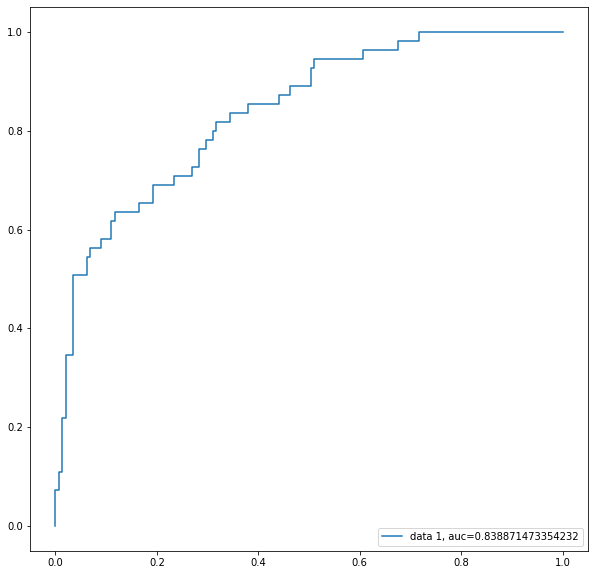

              precision    recall  f1-score   support

           0       0.84      0.94      0.89       145
           1       0.78      0.51      0.62        55

    accuracy                           0.82       200
   macro avg       0.81      0.73      0.75       200
weighted avg       0.82      0.82      0.81       200



In [28]:
y_pred = plot_roc_curve(clf, X_test, y_test)
print(classification_report(y_test, y_pred))

As expected, we can only see marginal improvements.

Next, I wanted to make use of SKLearn's pipeline functionality, plus try to only keep prime components for the MLPClassifier (just to make cross-validation faster). Since we have a tiny dataset and MLP is quite powerful, I expect it to overfit the data easily, which is why I'm opting for smaller layer sizes and fewer neurons.

In [29]:
# Define a pipeline to search for the best combination of PCA truncation
pca = PCA()
mlp = MLPClassifier(max_iter=2000)
pipe = Pipeline(steps=[('PCA', pca),('MLPClassifier', mlp)])


param_dist = {'PCA__n_components': stats.randint(1, len(X_train.columns)),  
              'MLPClassifier__hidden_layer_sizes': [(stats.randint.rvs(1,38,1), stats.randint.rvs(1,38,1),stats.randint.rvs(1,38,1),), 
                                                    (stats.randint.rvs(1,38,1), stats.randint.rvs(1,38,1),), 
                                                    (stats.randint.rvs(1,38,1),)],
              'MLPClassifier__activation': ['tanh', 'relu', 'logistic'],
              'MLPClassifier__solver': ['sgd', 'adam', 'lbfgs'],
              'MLPClassifier__alpha': stats.uniform(0.0001, 0.9),
              'MLPClassifier__learning_rate': ['constant','adaptive']
             }

search = RandomizedSearchCV(pipe, param_dist, n_jobs=-1, n_iter=15, verbose=10, error_score='raise')
search.fit(X_train, y_train)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
Best parameter (CV score=0.764):
{'MLPClassifier__activation': 'logistic', 'MLPClassifier__alpha': 0.1091647459830606, 'MLPClassifier__hidden_layer_sizes': (13,), 'MLPClassifier__learning_rate': 'constant', 'MLPClassifier__solver': 'adam', 'PCA__n_components': 26}


We can take a look at how PCA performed as we increased the number of components:

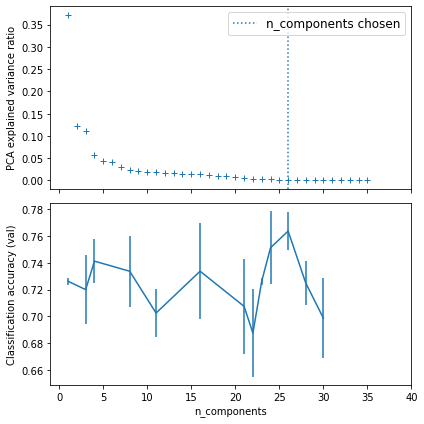

In [30]:
pca.fit(X_train)

fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True, figsize=(6, 6))
ax0.plot(np.arange(1, pca.n_components_ + 1),
         pca.explained_variance_ratio_, '+', linewidth=2)
ax0.set_ylabel('PCA explained variance ratio')

ax0.axvline(search.best_estimator_.named_steps['PCA'].n_components,
            linestyle=':', label='n_components chosen')
ax0.legend(prop=dict(size=12))

results = pd.DataFrame(search.cv_results_)
components_col = 'param_PCA__n_components'
best_clfs = results.groupby(components_col).apply(
    lambda g: g.nlargest(1, 'mean_test_score'))

best_clfs.plot(x=components_col, y='mean_test_score', yerr='std_test_score',
               legend=False, ax=ax1)
ax1.set_ylabel('Classification accuracy (val)')
ax1.set_xlabel('n_components')

plt.xlim(-1, 40)

plt.tight_layout()
plt.show()

Accuracy 0.805


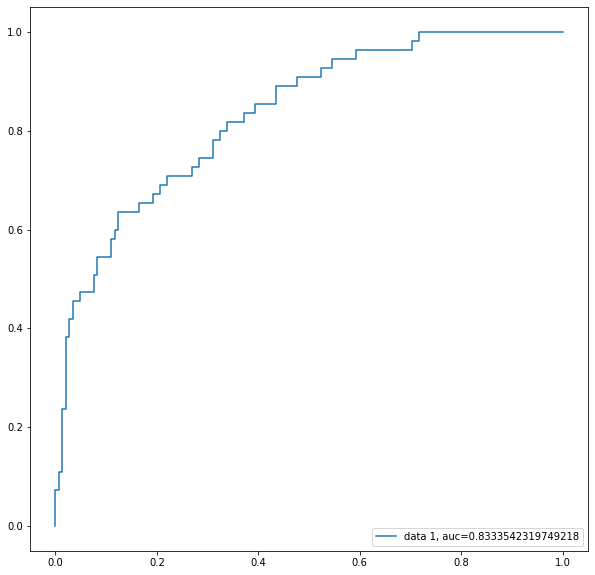

              precision    recall  f1-score   support

           0       0.83      0.92      0.87       145
           1       0.71      0.49      0.58        55

    accuracy                           0.81       200
   macro avg       0.77      0.71      0.73       200
weighted avg       0.80      0.81      0.79       200



In [31]:
y_pred = plot_roc_curve(search, X_test, y_test)
print(classification_report(y_test, y_pred))

This resulted in a marginally worse model, which I attribute to the data loss during PCA.

Finally, let's take a look at what the most important features are. For this, I'll train a random forest. I'll try to combat the class imbalance by letting the algorithm adjust the class weights.

In [32]:
rfc = RandomForestClassifier(class_weight='balanced', min_samples_split=2, n_jobs=-1)
rfc.fit(X_train, y_train)
rfc.score(X_test, y_test)

0.775

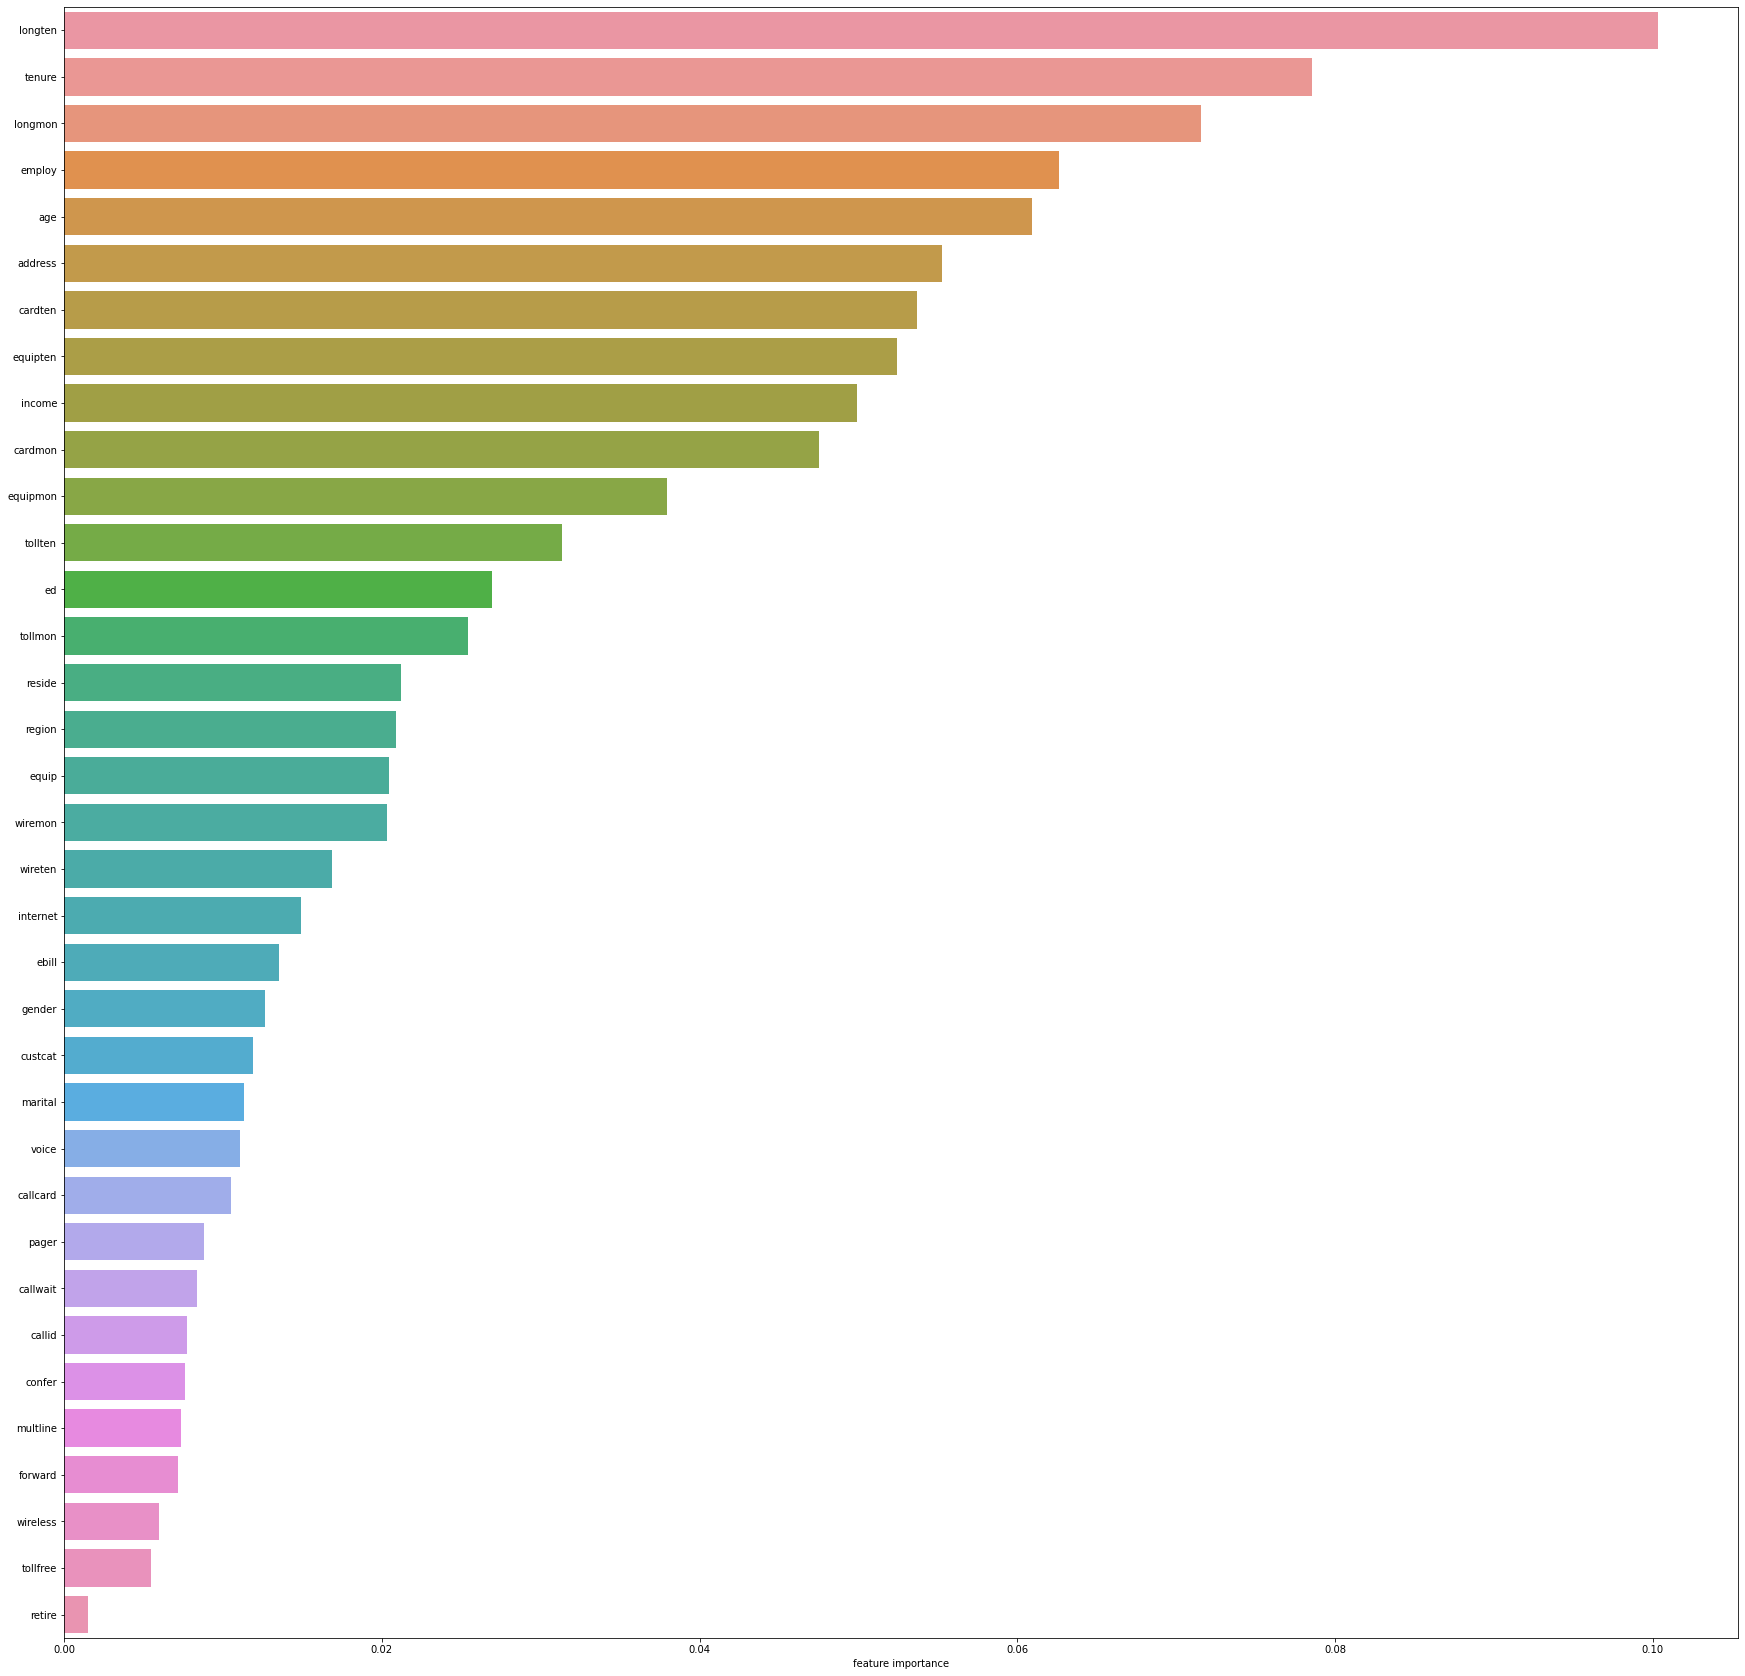

In [33]:
df_feature_importance = pd.DataFrame(rfc.feature_importances_, index=X.columns, columns=['feature importance']).sort_values('feature importance', ascending=False)
fig, ax = plt.subplots(figsize=(30,30))
ax = sns.barplot(x="feature importance", y=df_feature_importance.index, data=df_feature_importance, orient='h')

Accuracy 0.805


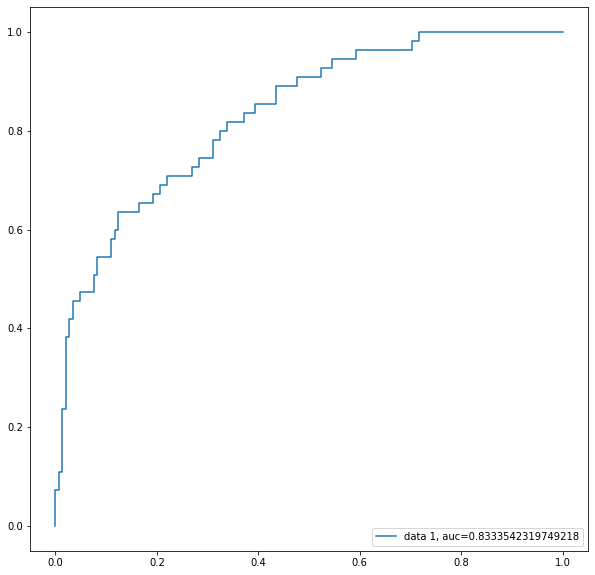

              precision    recall  f1-score   support

           0       0.83      0.92      0.87       145
           1       0.71      0.49      0.58        55

    accuracy                           0.81       200
   macro avg       0.77      0.71      0.73       200
weighted avg       0.80      0.81      0.79       200



In [34]:
y_pred = plot_roc_curve(search, X_test, y_test)
print(classification_report(y_test, y_pred))

## Conclusion

Interestingly enough, there were only marginal improvements achieved by performing the necessary data transformations, and the best model with the 0.838 ROC AUC was almost performing the same as the inintial model we tried with the raw data with logistic regression. This is the model I'd recommend using - however, it's worth noting, it's still not exceptional at predicting churn (but is quite adequate in predicting who won't churn) - as can be see in the precision and recall scores for class 1. Only 78 of 100 predicted to churn will actually churn (so we get a ~22% false positive rate for the model), and it only catches 51% of the actual people who will churn (49% false negative rate for churners). Still, catching around half the people who try to leave can lead to tangible increase in business performance!

Since we're dealing with a tiniy dataset and most models I tried performed similarly, I think this now comes down to data limiatations - there's no more information the models can gather from the data. As a next step I would propose getting more data, and especially, try to get more data from the underrepresented class. It's also worth noting that some ideas I tried that should've improved the model in theory actually made things worse, so I left them out from the final analysis (detailed below).

Another improvement we could try is to perform a more excessive randomized search on the best model (logistic regression). Although I used the CV version, which automatically performs parameter optimization, it might be worth looking into it some more. 

## Things I tried that didn't improve performance (but in fact, made it worse):

I've noticed on the histograms that there are some outliers in the dataset. Since I didn't have time to remove them in a more precise manner, I opted to use an outlier removal method, but this did not improve the models (actually, it made them worse), so I opted not to use this for my final model. I think this comes down to LOF deleting ca. 10% of the dataset, which at this size is quite impactful.

In [257]:
clf = LocalOutlierFactor(n_neighbors=20)
y_pred = (clf.fit_predict(X))
outliers = X[y_pred == -1] 
df = df[y_pred != -1]

Since there was a class imbalance present, I also tried upsampling the underrepresented class. For this, I chose SMOTE. This also only made model performances worse, so I ended up not using it. Might be important to post-process the model if upsampling. Since the classifier will expect the relative class frequencies in operation to be the same as those in the training set meaning oversampling the minority class in the training set, the classifier is likely to over-predict that class in operational use. To combat this, post-processing the output of the classifier might be needed, so that it doesn't over-predict the minority class on the test set.



In [264]:
oversample = SMOTE()
X_train, y_train = oversample.fit_resample(X_train, y_train)
y_train.value_counts()

0    518
1    518
Name: churn, dtype: int64